<font size="5">IMPORTING DEPENDENCIES</font>

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pprint as pp
import os
from twilio.rest import Client

from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

<font size="5">LOAD THE DATA FROM THE DIRECTORY</font>

In [2]:
# Load the data from the directory
data_dir = r"New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"

<font size="5">DEFINING THE IMAGE DATA GENERATORS</font>

In [3]:
# Define the image data generators
train_datagen = ImageDataGenerator()

validation_datagen = ImageDataGenerator(
    validation_split=0.5)
#DATA:
train_set = train_datagen.flow_from_directory(
          train_dir,
          target_size=(256,256),
          batch_size=32,
          seed=101, 
          shuffle=True,
          class_mode='categorical',
          )

test_set = validation_datagen.flow_from_directory(
          valid_dir,
          target_size=(256,256),
          batch_size=32,
          shuffle=False,
          # seed=101,
          class_mode='categorical',
          subset = "training")

val_set = validation_datagen.flow_from_directory(
          valid_dir,
          target_size=(256,256),
          batch_size=32,
          shuffle=True,
          # seed=101,
          class_mode='categorical',
          subset = "validation")

Found 70295 images belonging to 38 classes.
Found 8795 images belonging to 38 classes.
Found 8777 images belonging to 38 classes.


<font size="5">CLASSFICATION OF THE DISEASES</font>

In [4]:
# Classifiying the diseases
diseases = os.listdir(train_dir)
# printing the disease names
pp.pprint(diseases)
print("\nTotal disease classes are: {}".format(len(diseases)))

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___healthy',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spid

<font size="5">CLASSIFICATION OF THE PLANTS</font>

In [5]:
# Classifying the plants
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")
# number of unique plants
print("\nNumber of plants: {}".format(len(plants)))
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Unique Plants are: 
['Apple', 'Blueberry', 'Cherry_(including_sour)', 'Corn_(maize)', 'Grape', 'Orange', 'Peach', 'Pepper,_bell', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']

Number of plants: 14
Number of diseases: 26


<font size="5">CREATING DATAFRAME FOR THE COUNT OF IMAGES FOR EACH DISEASE</font>

In [6]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Apple___Apple_scab,2016
Apple___Black_rot,1987
Apple___Cedar_apple_rust,1760
Apple___healthy,2008
Blueberry___healthy,1816
Cherry_(including_sour)___healthy,1826
Cherry_(including_sour)___Powdery_mildew,1683
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,1642
Corn_(maize)___Common_rust_,1907
Corn_(maize)___healthy,1859


<font size="5">PLOTTING THE COUNT OF IMAGES FOR EACH DISEASE</font>

Text(0.5, 1.0, 'Images per each class of plant disease')

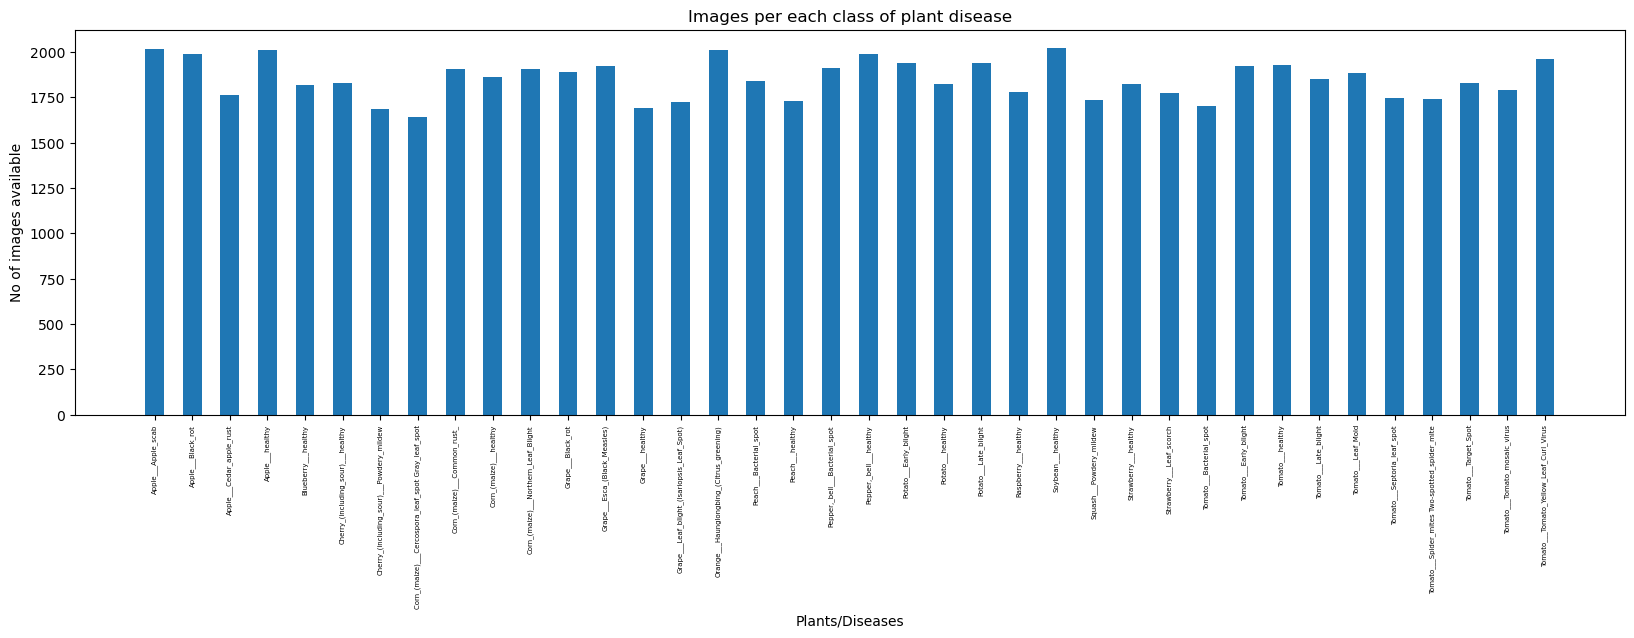

In [7]:
# plotting number of images available for each disease
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.5)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

<font size="5">SAMPLE TRAINING IMAGES</font>

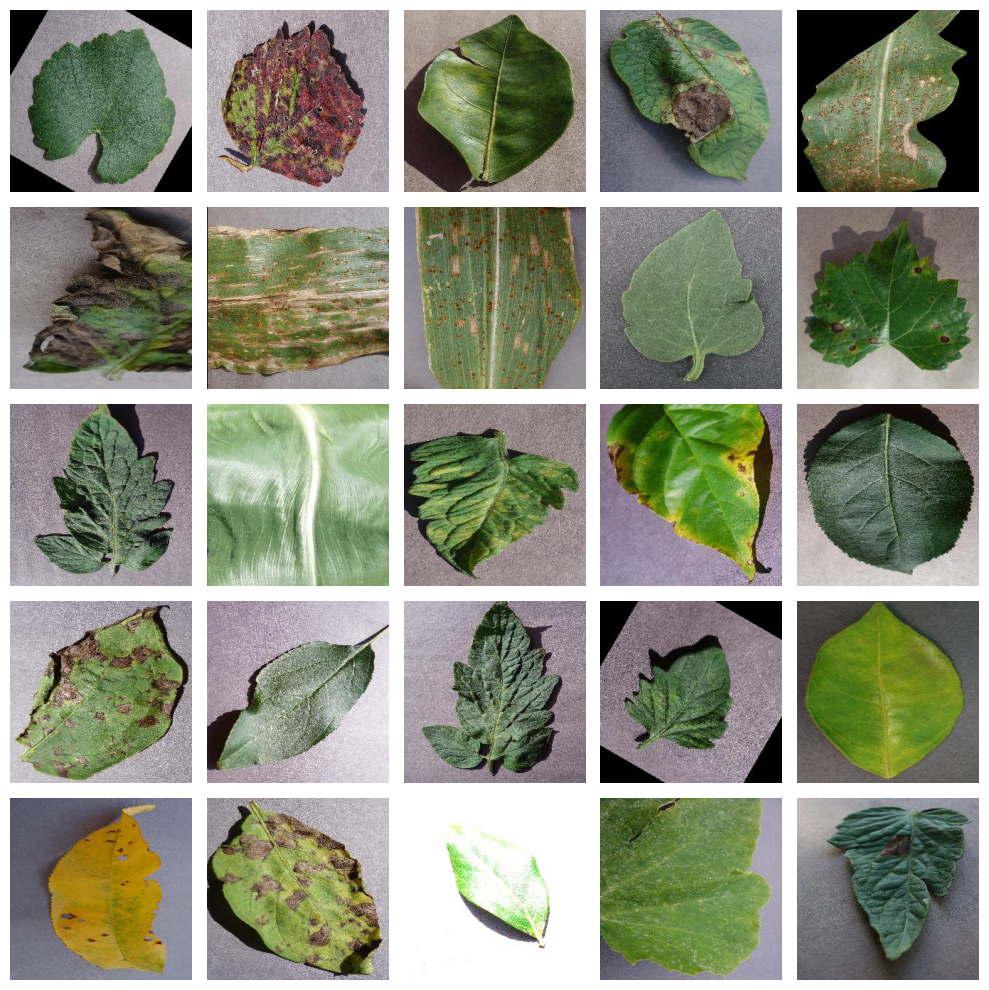

In [9]:
# This function will plot images in the form of a grid with 5 row and 5 columns where images are placed in each column.
sample_training_images, _ = next(train_set)
def plotImages(images_arr):
    fig, axes = plt.subplots(5, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
      
        ax.imshow(img.astype('uint8'))
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images)

<font size="5">PROCESSED IMAGE</font>

Found 70295 images belonging to 38 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


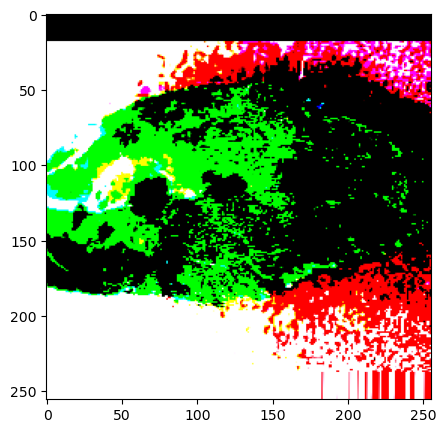

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


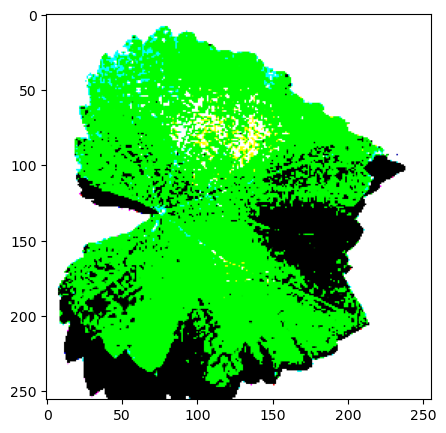

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


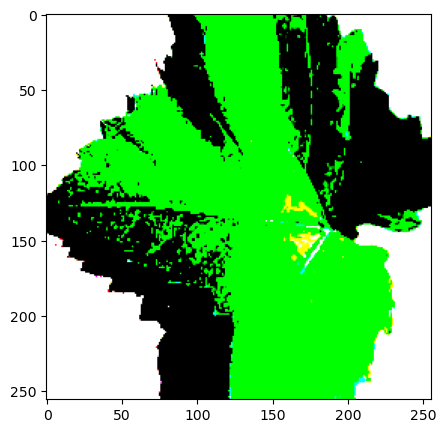

In [11]:
# # Plot processed image
# train_datagen = ImageDataGenerator(zoom_range= 0.5, shear_range= 0.3, horizontal_flip= True, preprocessing_function= preprocess_input)
# train = train_datagen.flow_from_directory(directory= r"New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train")
# t_img, label = train.next()

# def plotImage(img_arr,label):
#     for im, l in zip(img_arr, label):
#         plt.figure(figsize =(5,5))
#         plt.imshow(im)
#         plt.show()
        
# plotImage(t_img[:3], label[:3])

<font size="5">LOADING THE VGG19 MODEL</font>

In [10]:
# Load the VGG19 model
base_model = VGG19(input_shape=(256,256,3), include_top=False)

<font size="5">FREEZING THE LAYERS</font>

In [11]:
# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

<font size="5">ADDING NEW FLATTEN AND DENSE LAYER</font>

In [13]:
# Add new flatten and dense layer for classification
X = Flatten()(base_model.output)
X = Dense(units=38, activation='softmax')(X)
#creating model
model = Model(base_model.input, X)

In [13]:
# model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

<font size="5">MODEL COMPILING</font>

In [14]:
# Model compiling
model.compile(optimizer= 'adam', 
              loss= keras.losses.categorical_crossentropy, 
              metrics= ['accuracy'])

<font size="5">DEFINING CALLBACKS</font>

In [15]:
# Define callbacks

# Early Stopping
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1)

# Model Checkpoint
mc = ModelCheckpoint(filepath="best_model.h5", 
                    monitor='val_accuracy', 
                    min_delta=0.01, 
                    patience=3, 
                    verbose=1, 
                    save_best_model=True)
cb = [es, mc]

<font size="5">FITTING THE MODEL</font>

In [128]:
# # Fit the model
# his = model.fit(train_set, 
#                steps_per_epoch=100,
#                epochs=10,
#                verbose=1, 
#                callbacks=cb, 
#                validation_data=val_set, 
#                validation_steps=100)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 12.5271 - accuracy: 0.6303
Epoch 1: saving model to best_model.h5
100/100 [==============================] - 22s 213ms/step - loss: 12.5271 - accuracy: 0.6303 - val_loss: 8.7480 - val_accuracy: 0.7431
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 6.3578 - accuracy: 0.8203
Epoch 2: saving model to best_model.h5
100/100 [==============================] - 21s 212ms/step - loss: 6.3578 - accuracy: 0.8203 - val_loss: 7.3097 - val_accuracy: 0.8053
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 6.1495 - accuracy: 0.8408
Epoch 3: saving model to best_model.h5
100/100 [==============================] - 21s 214ms/step - loss: 6.1495 - accuracy: 0.8408 - val_loss: 4.6245 - val_accuracy: 0.8797
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 5.6585 - accuracy: 0.8641
Epoch 4: saving model to best_model.h5
100/100 [==============================] - 21s 209ms/ste

In [35]:
#h = his.history
#h.keys()

<font size="5">PLOTTING MODEL ACCURACY AND LOSS</font>

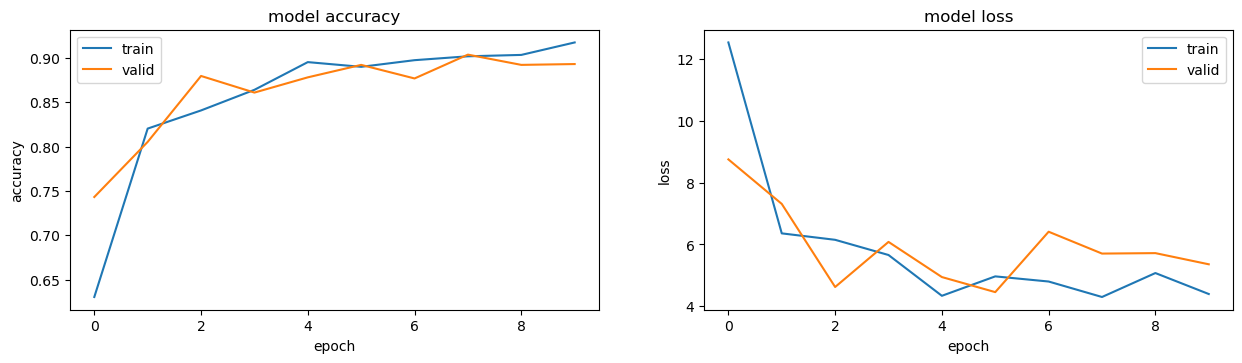

In [130]:
# # Plotting Accuracy vs Validation Accuracy and Plotting Loss vs Validation loss
# plt.figure(1, figsize = (15,8)) 
# plt.subplot(221)  
# plt.plot(h['accuracy'])  
# plt.plot(h['val_accuracy'])  
# plt.title('model accuracy')  
# plt.ylabel('accuracy')  
# plt.xlabel('epoch')  
# plt.legend(['train', 'valid']) 
    
# plt.subplot(222)  
# plt.plot(h['loss'])  
# plt.plot(h['val_loss'])  
# plt.title('model loss')  
# plt.ylabel('loss')  
# plt.xlabel('epoch')  
# plt.legend(['train', 'valid']) 
# plt.show()


<font size="5">LOADING THE BEST MODEL</font>

In [8]:
# Load the best model
model = load_model("best_model.h5")

<font size="5">ACCURACY OF THE MODEL</font>

In [20]:
# # #Accuracy of the model
# acc = model.evaluate(val_set)[1]

# print(f"Accuracy of your model is {acc*100} %")

275/275 [==============================] - 146s 461ms/step - loss: 4.8067 - accuracy: 0.9011
Accuracy of your model is 90.11051654815674 %


<font size="5">CREATING DICTIONARY FOR THE LABELS</font>

In [11]:
# Create a dictionary for class labels
ref = dict(zip(list(train_set.class_indices.values()), list(train_set.class_indices.keys())))

<font size="5">DEFINING PREDICTION FUNCTION</font>

In [12]:
# Define a function for prediction
def prediction(path):
    
    a=0
    img = load_img(path, target_size= (256,256))
    i = img_to_array(img)
    plt.figure(figsize =(5,5))
    plt.imshow(img)
    plt.show()
    im = preprocess_input(i)
    img = np.expand_dims(im, axis = 0)
    pred = np.argmax(model.predict(img))
    print(f"\nThe image belongs to {ref[pred]}")
    if "healthy" in f'{ref[pred]}':
        a = 1
    return a


<font size="5">MODEL PREDICTION</font>

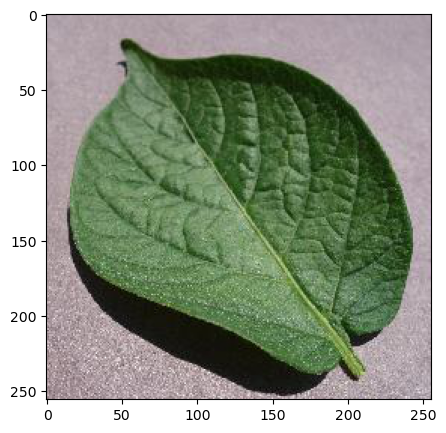

1/1 [==============================] - 0s 46ms/step

The image belongs to Potato___healthy
1
Sent from your Twilio trial account - Healthy


In [13]:
path = r"test\test\PotatoHealthy1.JPG"
b = prediction(path)
print(b)

account_sid = "****************************"
auth_token = "****************************"
client = Client(account_sid, auth_token)

if b==1:
    message = client.messages.create(
        body="Healthy",
        from_="*************,
        to="*************"
    )
    print(message.body)

else:
    message = client.messages.create(
        body="Diseased",
        from_="*************,
        to="*************"
    )
    print(message.body)

In [45]:
#train_set.class_indices